# Group Final project

### *Group24: Haibin Yu, Eric Zhang, Muhan Yang, Shuhao Zhang*

## Title

An observation into testing the existence of the gender wage gap in Canada in 2016.

## Introduction

The gender wage gap refers to the difference between wages earned by men and women, which can be measured using the difference in either mean or median of the wages (*The Gender Wage Gap: It’s More Than You Think*, n.d.).

**Question:** Is there a significant difference in wages between men and women in Canada in 2016 in the data?

The data set is a DTA file of the 2016 Canadian census downloaded from the website of Statistics Canada (see url: https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/index-eng.cfm), containing 16 columns of variables and 391,938 rows. This data describes the enumeration of Canadian residents in 2016. The data is filtered to contain only the variables of interest: "sex" and “wages”. The sex variable in this dataset is a categorical variable represented numerically with 1 and 2 representing female and male, respectively. The variable “wages” is a quantitative variable represented by whole numbers above 0.


The response variable is the wage of the individual observed represented by “wages”.
The location parameter to be used to describe the center of the wage distribution is the median as it will not be affected by outliers in the wage data.
The scale parameter to be used is the standard deviation of wages which can be used to describe the variability of wages between males and females.

The null hypothesis for this test is that there is no difference in wages between males and females in the dataset. The alternative hypothesis would be the existence of a difference in wages between the males and females (Pelletier, 2019). A t-test can be used to compare the median wages of males and females. Based on the p-value of the test it can be determined whether or not the null hypothesis should be rejected and determine the existence of a significant differences in wages between males and females in the dataset.



## Methods and Results

In [4]:
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(haven)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




### Table 1: Canadian Census 2016 Dataset - untidy

In [5]:
# loading the dataset
dropbox_url <- "https://dl.dropboxusercontent.com/s/lft2crtr48tu2p4/census2016.dta?dl=0"
read_dta(dropbox_url) -> data
head(data)

ppsort,agegrp,ageimm,cip2011,fol,hdgree,immstat,kol,lfact,locstud,mrkinc,pkids,pr,sex,vismin,wages
<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>
453141,11,99,8,1,4,1,1,1,6,97000,1,35,2,13,95000
732612,12,99,6,1,9,1,3,1,6,41000,1,35,1,13,19000
143665,15,99,5,2,6,1,3,1,2,30000,0,11,1,13,29000
52611,14,99,11,2,3,1,2,1,5,54000,0,24,2,13,52000
36927,8,99,13,1,2,1,1,1,99,27000,1,35,2,13,27000
268123,11,99,13,1,2,1,1,1,99,40000,1,35,2,13,57000


### Table 2: Cleaned Sex and Wages Data

In [6]:
# filter data with columns needed - sex and wages
data <- data %>%
    select(sex, wages) %>%
# convert sex from numeric form into categorical form for plotting later
    mutate(sex = factor(sex, labels = c("female", "male"))) %>% 
    filter(!is.na(wages), wages != "1")
head(data)

sex,wages
<fct>,<dbl>
male,95000
female,19000
female,29000
male,52000
male,27000
male,57000


### Chart 1: Boxplot of Men vs. Women Wages in Canada in 2016

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Removed 8105 rows containing non-finite values (stat_boxplot).”


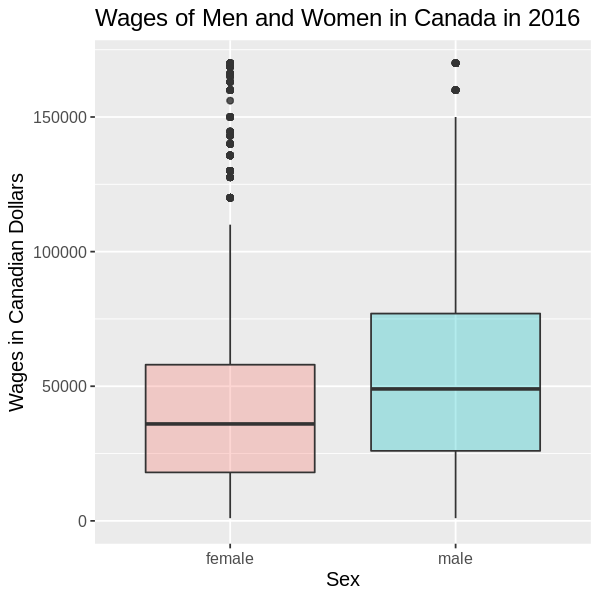

In [7]:
# using boxplot to plot the relevant raw data, as it helps to get a glimpse of the wage range of each sex and compare sample statistics
  # like median and interquartile range in two groups

data <- 
    data %>% 
    filter(sex %in% c("female", "male"))

sex_wages_boxplots <- data %>% 
    ggplot() +
    geom_boxplot(aes(sex, wages, fill = sex),
                alpha = 0.3) + # change transparency of colours
    ylim(0,170000) + # find a suitable limit for wages (y-axis) after looking the graph with outliers beforehand
    theme(text = element_text(size = 12)) +
    ggtitle("Wages of Men and Women in Canada in 2016") + 
    xlab("Sex") + 
    ylab("Wages in Canadian Dollars") +
    guides(fill = FALSE)

options(repr.plot.width = 5, repr.plot.height = 5)
sex_wages_boxplots

### Table 3: Estimates of the Parameter - Median, Mean, Standard Deviation, and Number of Data in Each Sex

In [8]:
# filter out all NA values for wages, compute estimates of the parameter in the following table of summary 
# including median, mean and standard deviation of wages, and the total number of people for both sexes respectively

data_summary <- data %>%
    filter(!is.na(wages)) %>%
    group_by(sex) %>%
    summarize(med = median(wages),
              mean = mean(wages),
             sd = sd(wages),
             n = n())
data_summary

sex,med,mean,sd,n
<fct>,<dbl>,<dbl>,<dbl>,<int>
female,36000,43954.87,38693.30,164476
male,51000,65095.04,79952.77,176072


### Chart 2: Wages Data Distribution in Canada in 2016

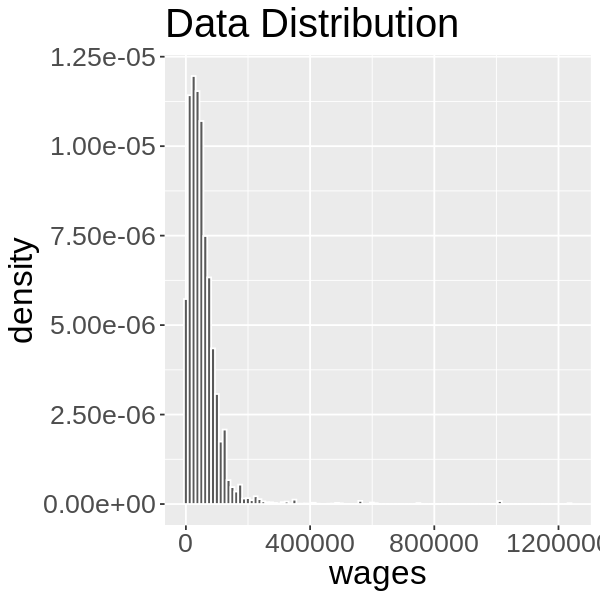

In [9]:
 ggplot(data, aes(x = wages)) + 
    geom_histogram(bins = 100, aes(y = ..density..), color = 'white') +
    ggtitle("Data Distribution") +
    theme(text = element_text(size = 20))

The plot above showed that wages in the sample are skewed to the right, mostly ranged from 0 to around 200,000 with a few outliers at 600,000 and 900,000.

In [10]:
# the mean and standard deviation for each group (males and females)
male_data <- data %>% filter(sex == "male")
female_data <- data %>% filter(sex == "female")

male_mean <- mean(male_data$wages)
female_mean <- mean(female_data$wages)

male_sd <- sd(male_data$wages)
female_sd <- sd(female_data$wages)

# total number of sample in each gender subgroups
male_n <- nrow(male_data)
female_n <- nrow(female_data)

# exact number for the information above see data_summary (Table 3)


# calculate the mean difference and the standard error for computing confidence interval later
mean_diff <- male_mean - female_mean

standard_error <- sqrt((male_sd^2/male_n)+(female_sd^2/female_n))


# calculate the confidence interval for the mean difference
alpha <- 0.05  # To compute 95% confidence interval, we have 5% of being wrong
t_value <- qt(1 - alpha/2, df = male_n + female_n - 2) # two-tailed t-test with a significance level of .05


lower_bound <- mean_diff - t_value * standard_error
upper_bound <- mean_diff + t_value * standard_error

confidence_interval <- c(lower_bound, upper_bound)
confidence_interval

[1] 20722.51 21557.82

Numbers obtained above are the 95% confidence interval of the mean difference between Canadian male and female wages sample in 2016. They indicate that we are 95% confident that the difference between the mean of Canadian male and female wages in 2016 is between 20722.51 and 21557.82 Canadian dollars.

-------------
The section below will use both **asymptotics - Central Limit Theorem (CLT)** and **bootstrapping** to plot the sampling distribution of the two gender groups and perform a two-sample t-test later in the end to determine whether or not the gender wage gap exists. 

We are using both here because they both have cons specifically in our case, and we will determine our selection on these two options after.

For **asymptotics**, the location parameter used describe the center of the wage distribution will always be the mean instead of the median, according to the CLT. However, as being illustrated in Chart 1 and Chart 2, there is a relatively considerable amount of outliers in our data, which cannot be eliminated. It would be optimal for us to use the median, as the median is more robust to outliers and extreme values compared to the mean. The presence of outliers in the right-skewed distribution (Chart 2) could potentially increase the sample mean.

Whereas for **bootstrapping**, even though we can use the median difference as the location parameter, our sample size might be too large. It would be optimal to keep the bootstrap size the same as the original sample, as the variability of the point estimate can be roughly the same as for the original sample. And if taking a bootstrap size much smaller than the original sample size (which is in our case, as our sample size is too large), the standard error will be over-estimated and the bootstrap distribution will result in a larger standard deviation, which makes the distribution wider.

## Asymptotics

In [11]:
# using male and female wages data to calculate 95% confidence interval of the difference in means using CLT
male_wage <- male_data %>%
    pull(wages)
female_wage <- female_data %>%
    pull(wages)
wages_diff_means_ci <- 
    tibble(
        lower_ci = mean(male_wage) - mean(female_wage) - qnorm(0.975) * sqrt(var(male_wage)/length(male_wage) + var(female_wage)/length(female_wage)),
        upper_ci = mean(male_wage) - mean(female_wage) + qnorm(0.975) * sqrt(var(male_wage)/length(male_wage) + var(female_wage)/length(female_wage))
    )

### Table 4: 95% Confidence interval of difference in means of male and female wages using CLT

In [12]:
wages_diff_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
20722.51,21557.82


Table 4 indicates that we are 95% confident that the difference in means of male and female wages in Canada in 2016 falls between 20,722.51 and 21557.82 Canadian dollars.

In [13]:
set.seed(2023)
sample_mean <- 
    data %>% 
    rep_sample_n(reps = 10000, size = 1000, replace = FALSE) %>% 
    group_by(replicate) %>% 
    summarize(sample_mean = mean(wages))

In [2]:
sample_mean %>% 
ggplot(aes(x = sample_mean)) +
        geom_histogram(binwidth = 500) +
        xlab("Wage mean of sampling") +
         geom_vline(xintercept = wage_ci1[[1]]) +
        geom_vline(xintercept = wage_ci1[[2]]) +
        ggtitle("n = 10") 

ERROR: Error in sample_mean %>% ggplot(aes(x = sample_mean)): could not find function "%>%"


## Bootstrapping

We will start the bootstrapping by calculating 95% confidence interval for the bootstrapped median wage in each sex, and then we will plot two bootstrap distributions out. After that, the confidence interval of the difference in medians of two sex groups will be found via the infer package.

In [14]:
# bootstrap with 10000 replicates with a size of 1000, and calculate the median wage of each bootstrapped female sample
set.seed(2023)
sample_1 <- 
    female_data %>% 
    rep_sample_n(reps = 10000, size = 1000, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarize(bootstrap_median = median(wages))

# compute 95% confidence interval
wage_ci1 <- sample_1 %>% 
    get_confidence_interval(level = 0.95, type = "percentile")

### Table 5: Female bootstrapped median wage 95% confidence interval

In [15]:
wage_ci1

lower_ci,upper_ci
<dbl>,<dbl>
34000,39000


Table 5 indicates that we are 95% confidence that the female median wage in Canada in 2016 falls between 34,000 and 39,000 Canadian dollars.

In [16]:
# bootstrap with 10000 replicates with a size of 1000, and calculate the median wage of each bootstrapped male sample
set.seed(2023)
sample_2 <- 
    data %>% 
    rep_sample_n(reps = 10000, size = 1000, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarize(bootstrap_med = median(wages))

# compute 95% confidence interval
wage_ci2 <- sample_2 %>% 
    get_confidence_interval(level = 0.95, type = "percentile")

### Table 6: Male bootstrapped median wage 95% confidence interval

In [17]:
wage_ci2

lower_ci,upper_ci
<dbl>,<dbl>
40000,46000


Table 6 indicates that we are 95% confidence that the male median wage in Canada in 2016 falls between 40,000 and 46,000 Canadian dollars.

### Chart 3: Bootstrap distribution of Female Median Wages with 95% Confidence Interval

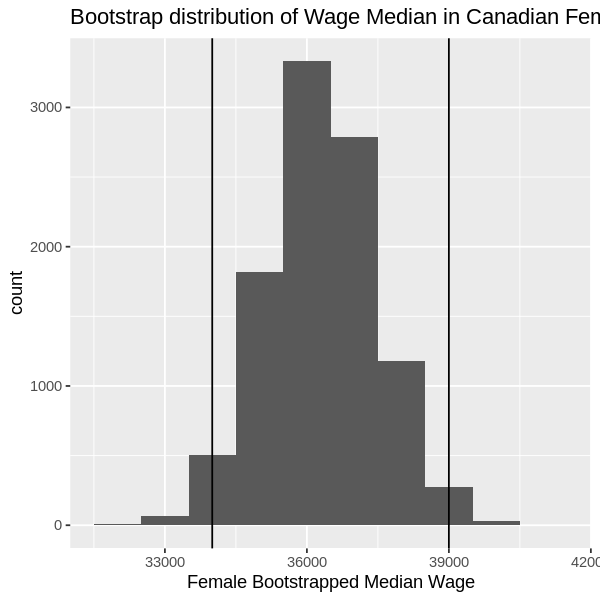

In [30]:
sample_1|>
ggplot(aes(x = bootstrap_median)) +
        geom_histogram(binwidth = 1000) + # find a suitable binwidth by looking at whether or not the visualization looks like normal
        xlab("Female Bootstrapped Median Wage") +
         geom_vline(xintercept = wage_ci1[[1]]) +
        geom_vline(xintercept = wage_ci1[[2]]) + # add female confidence interval
        ggtitle("Bootstrap distribution of Wage Median in Canadian Female in 2016") 

Chart 3 indicates that the female bootstrapped median wage is centred around 37,000 with a 95% confidence interval between 34,000 and 39,000 Canadian dollars.

### Chart 4: Bootstrap distribution of Male Median Wages with 95% Confidence Interval

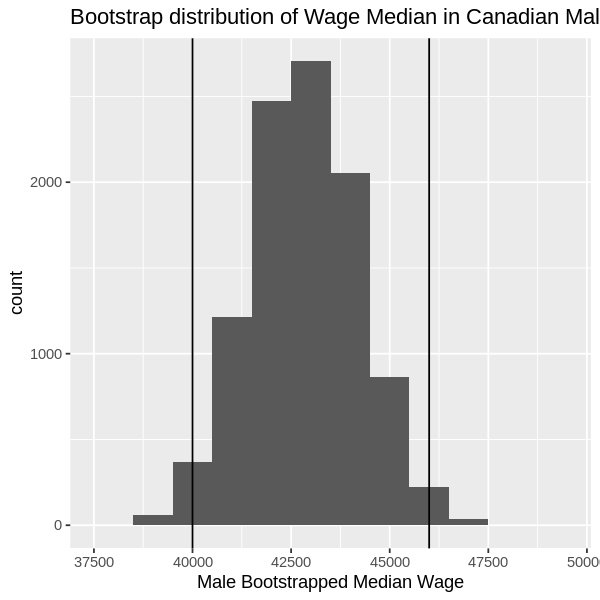

In [29]:
sample_2|>
ggplot(aes(x = bootstrap_med)) +
        geom_histogram(binwidth = 1000) +
        xlab("Male Bootstrapped Median Wage") +
         geom_vline(xintercept = wage_ci2[[1]]) +
        geom_vline(xintercept = wage_ci2[[2]]) +
        ggtitle("Bootstrap distribution of Wage Median in Canadian Male in 2016") 

Chart 4 indicates that the male bootstrapped median wage is centred around 43,000 with a 95% confidence interval between 40,000 and 46,000 Canadian dollars.

In [ ]:
# get confidence interval of the difference in medians using Bootstrapping by applying infer package
diff_in_med_wages_ci <- 
    data %>%
    specify(formula = wages ~ sex) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "diff in medians", order = c("male", "female")) %>%
    get_ci()

### Table 7: Confidence interval of difference in medians of male and female wages using bootstrapping

In [ ]:
diff_in_med_wages_ci

## Results using two-sample t-test

### Table 8: two-sample t-test results

In [20]:
# Perform t-test on wages between males and females
t_test_result <- t.test(wages ~ sex, data = data)

# Print the t-test result
t_test_table <- tidy(t_test_result)
t_test_table


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-21140.17,43954.87,65095.04,-99.2064,0,258062.9,-21557.82,-20722.51,Welch Two Sample t-test,two.sided


estimate: The difference between the average incomes of two groups (male and female) (estimate1 - estimate2).

estimate1: The mean income of females.

estimate2: The mean income of males.

conf.low: The lower limit of the 95% confidence interval for the difference in incomes between the two groups.

conf.high: The upper limit of the 95% confidence interval for the difference in incomes between the two groups.

method: The testing method used, which is Welch's two-sample t-test in this case.

alternative: The type of alternative hypothesis being tested, which is a two-sided test.

Table 8 indicates that the p-value after performing two-sample t-test is <.001, which is less than the significance level .05, so the null hypothesis is rejected. Therefore, we conclude that there is a statistically significant gender wage gap between the male and the female gender group in Canada in 2016.

## Discussion

After the data analysis, we conclude that the mean wage of males is much more than the mean wage of females. 
The difference of mean wages between males and females is about 20000 dollars which is a significant gap.
But one possible reason for this condition is that we compare the mean wages between males and females instead of median. Since there are plenty of outliers, using mean wages is not the most proper way. We tried to calculate the difference of median wages, but CLT cannot be applied to the median of the data. In general, males still have higher wage than females. Thus, balancing the wages between males and females seems to be necessary.

Before the research, we expect that males and females will have same mean wages while the result is totally different from our expectation. It is possible that the medians of wages of males and females are similar. However, there must be males who have extremely high wages. According to the research, here is our future question: Are there any elements other than gender that affects wages?

## References


Pelletier, R., Patterson, M., & Moyer, M. (2019, October 7). *The gender wage gap in Canada: 1998 to 2018.* Retrieved March 16, 2023, from https://www150.statcan.gc.ca/n1/pub/75-004-m/75-004-m2019004-eng.htm 

*The Gender Wage Gap: It's More Than You Think.* (n.d.). Retrieved March 16, 2023, from https://www.payequity.gov.on.ca/en/LearnMore/GWG/Pages/default.aspx 
